<a href="https://colab.research.google.com/github/GDS-Education-Community-of-Practice/DSECOP/blob/rmastand/03_goodness_of_fit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Here are some necessary packages that we need to import to run this notebook

import numpy as np
import matplotlib.pyplot as plt
plt. rcParams["figure.figsize"] = (10, 6)

from google.colab import drive 
drive.mount("/content/drive/")

import os
os.chdir("/content/drive/My Drive/DSECOP/Colab Notebooks/")
!pwd

Mounted at /content/drive/
/content/drive/My Drive/DSECOP/Colab Notebooks


# How good is our fit model?

After performing a curve fit to data, we are left with the most probable values for the model parameters $\Theta$. However, the "best fit" is not necessarily a good fit.



* image of a bat fit*

**Activity:** Read in the dataset and bin it. Fit the data to a Poisson distribution, then a Gaussian distribution. Plot both fits and the histogram on the same plot. 


In [4]:
# First histogram the data

dataset_location = "counts_dataset_00.txt"

def read_in_dataset(file_loc):

  with open(file_loc, "r") as infile:
    dataset = infile.read().split(",")
    num_clicks_per_minute = np.array([int(x) for x in dataset if x != " "])

    return num_clicks_per_minute

num_clicks_per_minute = read_in_dataset(dataset_location)

clicks_per_minute_bin_edges = np.linspace(-.5,30.5,32)
clicks_per_minute_bin_centers = 0.5*(clicks_per_minute_bin_edges[1:]+clicks_per_minute_bin_edges[:-1])

  # We're using np.histogram() here as we don't necessarily need to see the plot of the histogram
n_i, bins = np.histogram(num_clicks_per_minute, clicks_per_minute_bin_edges, density = "True")

In [5]:
# define the fit functions

def poisson(n, l):

  return [(l**x)*np.exp(-l) / np.math.factorial(x) for x in n]

def gaussian(n, mu, sigma):

  return [(1.0/(sigma*np.sqrt(2*np.pi)))*np.exp(-(x-mu)**2/sigma**2) for x in n]

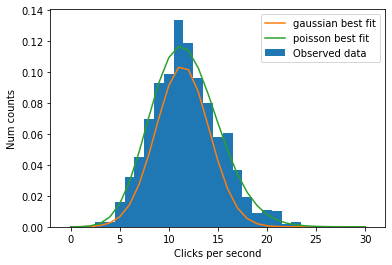

In [10]:
from scipy.optimize import curve_fit


popt_poisson, pcov_poisson = curve_fit(poisson, clicks_per_minute_bin_centers, n_i)
popt_gaussian, pcov_gaussian = curve_fit(gaussian, clicks_per_minute_bin_centers, n_i)




plt.figure()
plt.hist(num_clicks_per_minute, bins = clicks_per_minute_bin_edges, label = "Observed data", density = True)
plt.plot(clicks_per_minute_bin_centers, gaussian(clicks_per_minute_bin_centers, *popt_gaussian), label = "gaussian best fit")
plt.plot(clicks_per_minute_bin_centers, poisson(clicks_per_minute_bin_centers, *popt_poisson), label = "poisson best fit")

plt.legend()

plt.xlabel("Clicks per second")
plt.ylabel("Num counts")
plt.show()

## The $\chi^2$ test statistic

The *chi-square* goodness-of-fit test statistic is defined as

$$\chi^2 = \sum_i \frac{(O_i - E_i)^2}{E_i},$$

where $O_i$ is the observved value for a given bin $b_i$ and $E_i$ is the expected value for that, as calculated from the model fit function.

Using terms we have already defined, this is equivalent to 

$$\chi^2 = \sum_i \frac{(n_i - f(b_i, \Theta))^2}{f(b_i, \Theta)}.$$


**Activity:** Write a function to calculatw the $\chi^2$ test statistic given two arrays ```observed_vals``` and ```expected_vals```. Calculate $\chi^2$ for both the Poisson and the Gaussian fit. Which fit is better?

In [20]:
def chi2(observed_vals, expected_vals):

  chi2 = 0

  for i in range(len(observed_vals)):

    chi2 += ( (observed_vals[i] - expected_vals[i])**2 / expected_vals[i] )


  return chi2

exp_gaussian = gaussian(clicks_per_minute_bin_centers, *popt_gaussian)
exp_poisson = poisson(clicks_per_minute_bin_centers, *popt_poisson)


chi2_gaussian = chi2(n_i, exp_gaussian, num_obs-2)
chi2_poisson = chi2(n_i, exp_poisson, num_obs-1)

print(chi2_gaussian)
print(chi2_poisson)

1.8558887552251602
0.026151992453218274


A related test statistic is $\chi^2/\nu$, or the *reduced chi-square* / *chi-square per degrees of freedom*.

The degrees of freedom $\nu$ is equal to the number of observations made - the number of fit parameters in the model.

*Note*: There's a bit of ambiguous language here. Here, an "observation" is equivalent to observing $n_i$ counts in a given bin $b_i$. It is *not* equal to the number of measurements in a given dataset.

## Interpreting the $\chi^2$ test statistic

In the doing the previous exercises, you may have come to the conclusion that a lower $\chi^2$ test statistic is generally better, as we have better agreement between the observed data and the results predicted by the model. But how can we turn this general sentiment into something more rigorous?

### A mathematical aside: $\chi^2$ distribution

To fully understand the usefulness of the $chi^2$ test statistic, we need to understand the $\chi^2$ distribution. This is a probability distribution $f(x)$ given by

$$f_k(x) = \frac{x^{k/2 -1}e^{-x/2}}{2^{k/2}\Gamma(k/2)}, \hspace{7mm} (x \geq 0).$$

Here, $\Gamma(k/2)$ is the *Gamma function*. It's defined on integers by $\Gamma(m) = (m-1)!$ and is analytically continued to complex numbers,

To construct the probability distribution $f(x)$, we would execute the following steps:

1. Draw $k$ independent trials from the *standard normal* distribution (a gaussian with $\mu$ = 0 and $\sigma = 1$) to produce a list of measurements $z_1$, ..., $z_k$
2. Calculate the sum of the squares $Q = \sum_{i=1}^k z_i^2$

If steps 1 and 2 are repeated many times, then the variable $Q$ can be histogrammed to produce $f(x)$.

A plot from [Wikipedia](https://en.wikipedia.org/wiki/Chi-squared_distribution) is shown below, for a range of $k$ values.

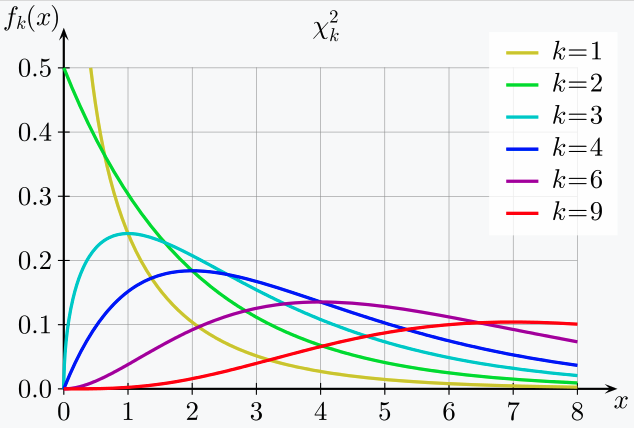




### Adding in physical context: f(x) and the $\chi^2$ test statistic

Now, let's outline how we can recover this theoretical distribution for $f(x)$ from a more realistic physical experiment.

Let's go back to your Geiger counter radioactivity experiment with the Uranium-234 sample. You record the number of counts per minute for as long as you can stand. At the end of that time period, you histogram your measurements using the binning scheme $b_i$ to get counts $n_i$ (let's assume $n_i$ are the normalized counts), fit the histogram to a Poisson distribution, and get a best-fit value $\lambda$.


The parameter $\lambda$ that you found each day should be close to the true value $\lambda^*$ of the theoretical poisson decay process for Urainium-234. But it will likely *not* match. Real experiments have fluctuations. The more measurements you take, the closer $\lambda$ will be to $\lambda^*$.


For each bin $b_i$, the true underlying process $\lambda^*$ would produce  $n_i^*$ (normalized) for each bin. But in your real-world, imperfect experiment. You actually observed $n_i$ counts. 

Let's say you do the Geiger counting experiment for several days in a row using the same binning scheme. By the [Central Limit Theorem](https://), the observation for each bin $n_i$ that you get each day will be randomly pulled from a gaussian with mean $n_i^*$ and standard deviation $\sqrt{n_i}$.

*Note:* If you are familiar with the Central Limit Theorem, you may know that the standard deviation should be $\frac{\sigma}{\sqrt{n}}$, where $\sigma$ is the standard deviation of the underlying process and $n$ is the number of measurements made. For counting experiemnts, the error on the number of counts $m$ in a bin is $\sqrt{m}$, and each day, we make one measurement per bin.

Then we have

$$\chi^2 = \sum_i \frac{(n_i - n_i^*)^2}{n_i}.$$

Now consider the quantity $\frac{(n_i - n_i^*)^2}{n_i}$ calculated for each bin $b_i$. Since we can identify $\sigma_i^2$ with $n_i$, then the quantity is equal to the normalized varianced. In other words, it's the variance for a random process pulled from a standard normal distribution. And this was the theoretical underpinning of the $\chi^2$ distribution $f(x)$ -- it's the num of a number of normalized variances.

*Note:* There's a subtlety here -- while $f(x)$ was defined as the sum over $k$ independent measurements, we identify $k$ not with the number of bins $I$, but rather with the degrees of freedom $\nu$ for our model fit. This is because our random draws of histograms bins are not actually independent for a normalized distribution.



### Using $\chi^2$ to articulate confidence in a model 

If we postulate a model to describe a given histogram, we can always curve fit that model to the histogram and recover a best-fit value for the parameters. But how can we quantitatively gauge our confidence that the model fit is a *good* fit to the data?

Consider the quantity

$$\alpha = \int_{\chi^2_{\alpha}}^\infty f_k(x) dx. $$

In other words, given some value $\chi^2_{\alpha}$, $\alpha$ is the probability that when we draw from the $\chi^2$ distribution $f_k(x)$, we recover a value larger than $\chi^2_{\alpha}$. 

This means if we measure $\chi^2$ for an experiment with $\nu$ degrees of freedom, then there is a probability $\alpha$ that our measurement of $\chi^2$ would be larger than $\chi^2_{\alpha}$ (which we would have to look up).

In practice, we would choose some small value of $\alpha$ (such as 0.05). We would then use a [lookup table](https://people.richland.edu/james/lecture/m170/tbl-chi.html) to find $\chi^2_{\alpha}$ based on the number of degrees of freedom that our binning system and model fit determine. Then if if the model function that we chose actually does describe the data, there is a 95\% chance that we will calculate $\chi^2$ that is less than $\chi^2_{\alpha}$.

So we then calculate $\chi^2$. What happens if this value is *larger* than $\chi^2_{\alpha}$? There are two possibilities.

1. The model actually did describe the data, and we had an anomalous experiment. 5% of experiments would of resulted in this, so maybe we're in that case?
2. The model does not describe the data.


### Hypothesis testing

You might be familiar with these concepts in the context of *hypothesis testing*. 

In this case, we define:

- $\mathcal{H}_0$, the *null hypothesis*: this is the situation where the model fit we have defined does describe the data.
- $\mathcal{H}_a$, the *alternative hypothesis*: this is the situation where the model fit we have defined does not describe the data.

If $\chi^2 > \chi^2_{\alpha}$, then we must reject the null hypothesis. ]

In this context, $\alpha$ is known as the *p-value*, or the *significance*.

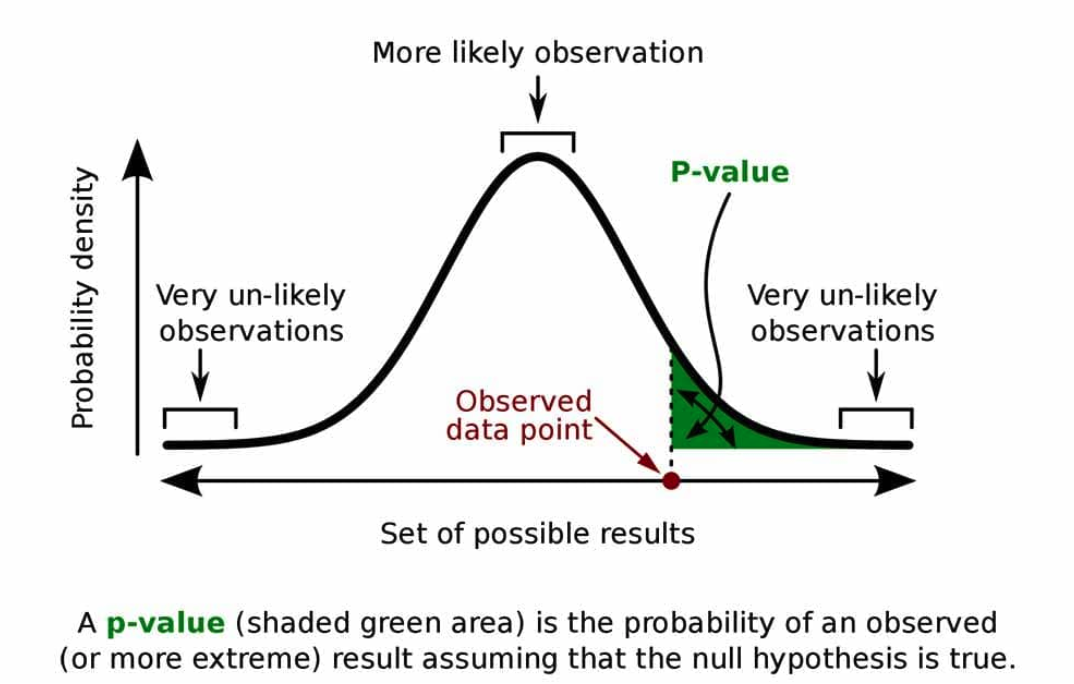

[Image source](https://www.simplypsychology.org/p-value.html)


**Activity:** Accept or reject the null hypotehsis for the Poisson case at your desired level of confidence. Then do it for the Gaussian case.